# Imports

In [1]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from top2vec import Top2Vec

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, LdaModel
from gensim import corpora

from scipy.cluster.hierarchy import ward, dendrogram

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import seaborn as sns
import numpy as np

from sentence_transformers import SentenceTransformer

from kneed import KneeLocator

C:\Users\ccronin\AppData\Roaming\Python\Python310\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\ccronin\AppData\Roaming\Python\Python310\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\ccronin\AppData\Roaming\Python\Python310\site-packages\umap\d

# Prep

In [2]:
docs = pd.read_excel('forlabeling.xlsx')

In [3]:
###############################################################################
### Functions to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    #word stemming    
    ps=PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return tokens


def nolinksnoemo(badstr):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    badstr = re.sub(r'http\S+', '', badstr) #links
    return re.sub(emoj,r'',badstr)

def ss(c):
    return c.split(' ')

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [4]:
ts = list(docs['titles'])
newlist = []
for i, v in enumerate(ts):
    totalcount = ts.count(v)
    count = ts[:i].count(v)
    newlist.append(v + str(count + 1) if totalcount > 1 else v)

docs['titles'] = newlist
docs['bodies'] = docs['bodies'].apply(nolinksnoemo)
docs['bodies'] = docs['bodies'].apply(clean_doc)
docs['bodies'] = docs['bodies'].apply(" ".join)

# Vectorizaiton

## TFIDF

In [5]:
Tfidf=TfidfVectorizer(ngram_range=(1,3),sublinear_tf=True, min_df=5, max_df=0.95)
TFIDF_vecs=Tfidf.fit_transform(docs['bodies'])  

## Word2Vec

In [6]:
modelw2v = Word2Vec(sentences=docs['bodies'].apply(ss), vector_size=100, workers=1, seed=42)
w2v_vecs = vectorize(docs['bodies'].apply(ss), model=modelw2v)

## Doc2Vec

In [7]:
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs['bodies'])]
# d2v = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
# d2v_vecs = d2v.dv.vectors 

In [8]:
xxx = docs['bodies'].apply(ss)

In [9]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(xxx)]
d2v = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
d2v_vecs = d2v.dv.vectors 

## BERT

In [10]:
model = SentenceTransformer('all-MiniLM-L6-v2')
bert_vecs = model.encode(docs['bodies'])

In [11]:
bert_vecs

array([[-0.00736925, -0.04533316,  0.07678442, ..., -0.01298811,
        -0.01114778,  0.00540941],
       [-0.00736925, -0.04533316,  0.07678442, ..., -0.01298811,
        -0.01114778,  0.00540941],
       [ 0.01040562, -0.0370839 , -0.01837397, ..., -0.05041099,
         0.05930256, -0.00051568],
       ...,
       [ 0.02210187, -0.03372992, -0.04400143, ..., -0.13200817,
        -0.03388318, -0.0350737 ],
       [-0.03058302, -0.065496  ,  0.0087982 , ..., -0.00437447,
         0.04639036, -0.03849751],
       [-0.0214714 , -0.05580322, -0.01579829, ..., -0.03213572,
         0.03315943, -0.00791917]], dtype=float32)

# Dimensionality Reduction

## PCA

In [12]:
pca = PCA(n_components=2, random_state=42)
cols = ["tab:blue", "tab:red"]
sns.set_palette(sns.set_palette(cols))

### TFIDF

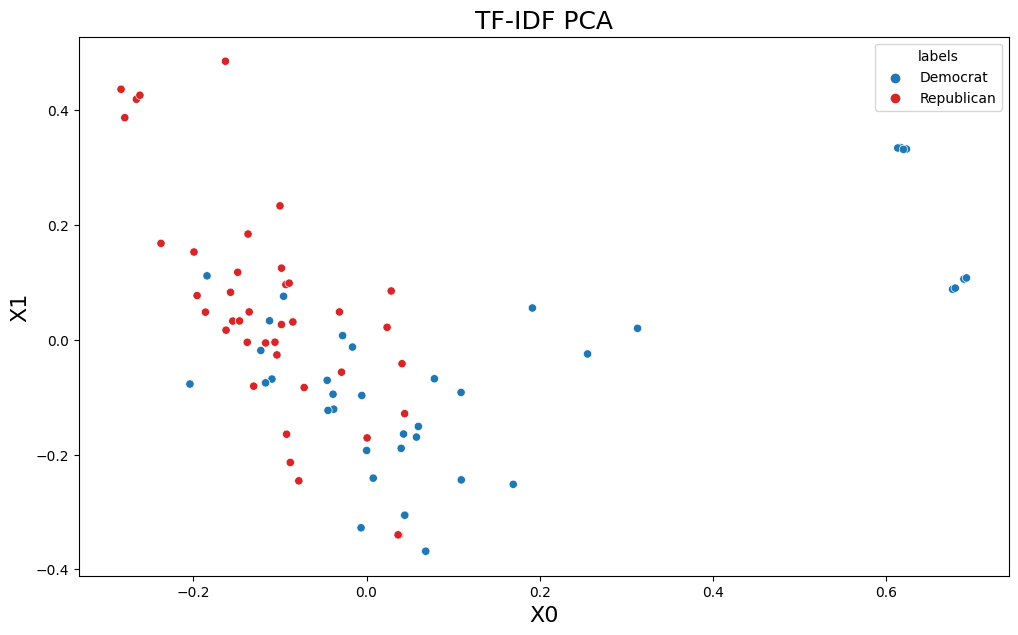

In [13]:
pca_vecs_tfidf = pca.fit_transform(TFIDF_vecs.toarray())

x0 = pca_vecs_tfidf[:, 0]
x1 = pca_vecs_tfidf[:, 1]

dfpca1 = pd.DataFrame()
dfpca1['labels'] = docs['labels']
dfpca1['x0'] = x0
dfpca1['x1'] = x1

cdic = {}
plt.figure(figsize=(12, 7))
plt.title("TF-IDF PCA", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=dfpca1, x='x0', y='x1', hue='labels')
plt.show()

### word2vec

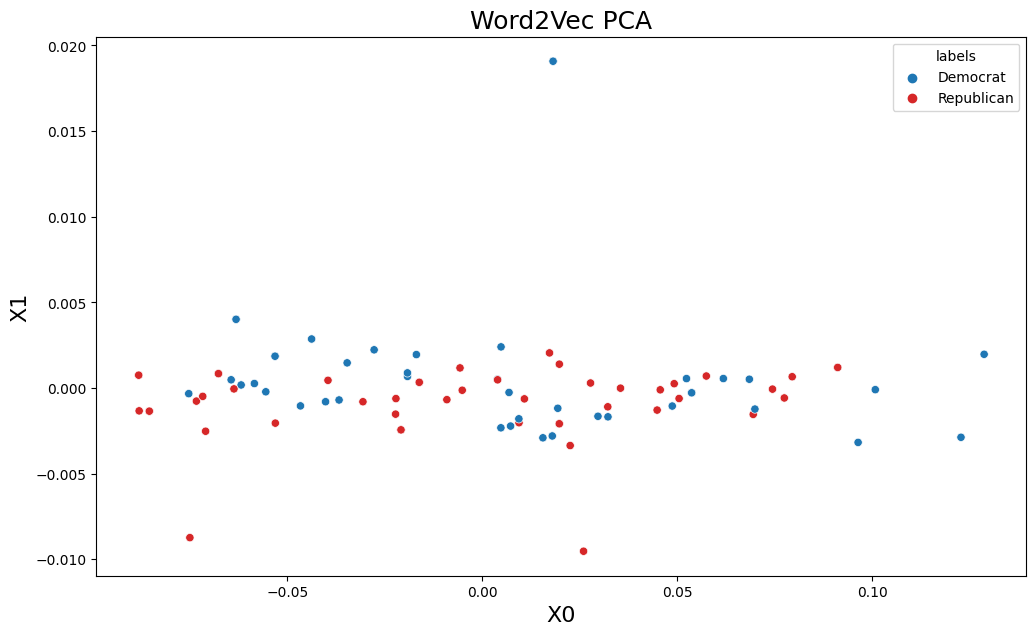

In [14]:
pca_vecs_w2v = pca.fit_transform(w2v_vecs)

x0 = pca_vecs_w2v[:, 0]
x1 = pca_vecs_w2v[:, 1]

dfpca_w2v = pd.DataFrame()
dfpca_w2v['labels'] = docs['labels']
dfpca_w2v['x0'] = x0
dfpca_w2v['x1'] = x1

plt.figure(figsize=(12, 7))
plt.title("Word2Vec PCA", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=dfpca_w2v, x='x0', y='x1', hue='labels')
plt.show()

### Doc2vec

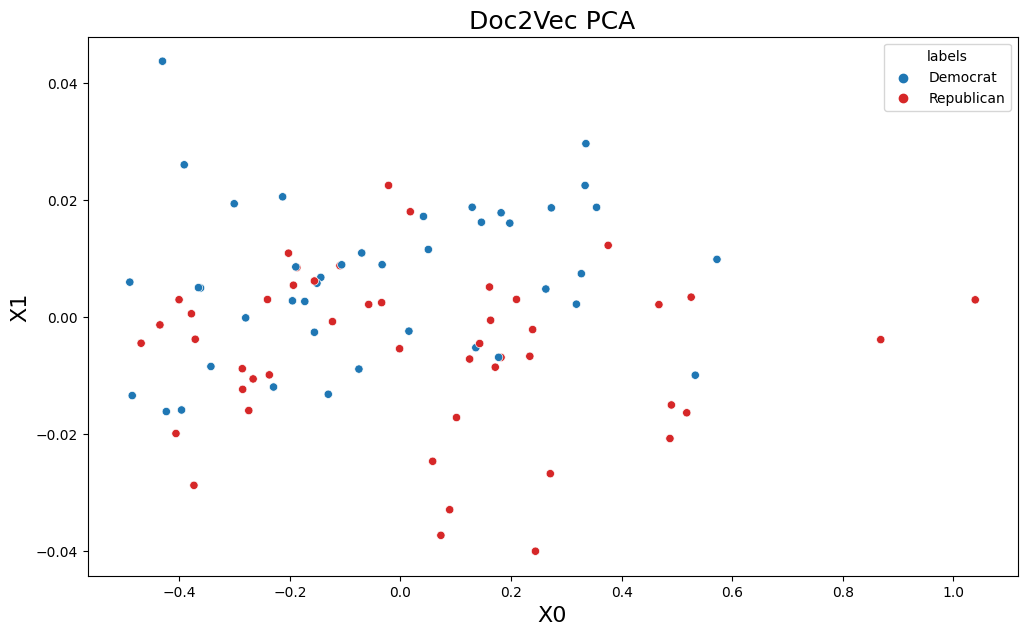

In [15]:
pca_vecs_d2v = pca.fit_transform(d2v_vecs)

x0 = pca_vecs_d2v[:, 0]
x1 = pca_vecs_d2v[:, 1]

dfpca_d2v = pd.DataFrame()
dfpca_d2v['labels'] = docs['labels']
dfpca_d2v['x0'] = x0
dfpca_d2v['x1'] = x1

plt.figure(figsize=(12, 7))
plt.title("Doc2Vec PCA", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=dfpca_d2v, x='x0', y='x1', hue='labels')
plt.show()

### BERT

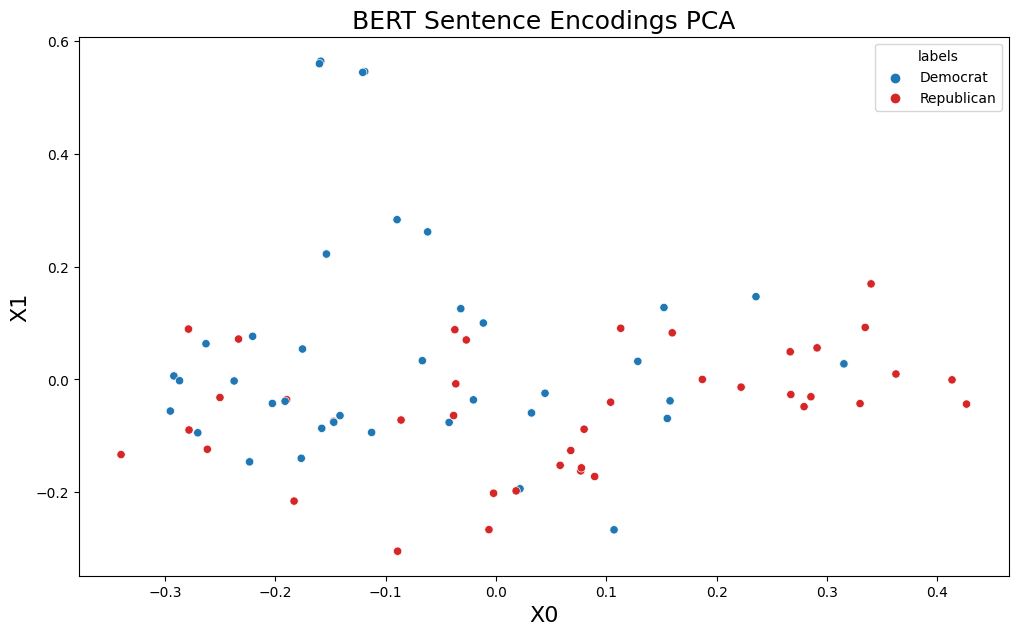

In [16]:
pca_vecs_bert = pca.fit_transform(bert_vecs)

x0 = pca_vecs_bert[:, 0]
x1 = pca_vecs_bert[:, 1]

dfpca_bert = pd.DataFrame()
dfpca_bert['labels'] = docs['labels']
dfpca_bert['x0'] = x0
dfpca_bert['x1'] = x1

plt.figure(figsize=(12, 7))
plt.title("BERT Sentence Encodings PCA", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=dfpca_bert, x='x0', y='x1', hue='labels')
plt.show()

In [37]:
d2v_vecs

array([[-0.0298361 , -0.06768901, -0.08075652, ..., -0.06976898,
         0.04749106,  0.01461464],
       [-0.03107907, -0.06791391, -0.08094314, ..., -0.07603741,
         0.04269151,  0.01852191],
       [-0.04908071, -0.10352957, -0.09269432, ..., -0.10273662,
         0.0707349 ,  0.00517106],
       ...,
       [-0.0287772 , -0.05187072, -0.06403498, ..., -0.06525294,
         0.04141973,  0.01344864],
       [-0.02146051, -0.04767499, -0.05863002, ..., -0.06945115,
         0.02526132,  0.00843828],
       [-0.01736268, -0.0686072 , -0.06806943, ..., -0.06024843,
         0.03221457,  0.01516987]], dtype=float32)

# Clustering

## KMeans

In [17]:
k=2
km = KMeans(n_clusters=k, random_state = 89)

In [18]:
def afunc(x):
    return int(len(x))

def pright(clusdf):
    piv = pd.pivot_table(clusdf, index='cluster', columns='label', aggfunc=afunc, fill_value=0).reset_index()[['Democrat', 'Republican']].to_dict(orient='index')
    c1dic = piv[0]
    c2dic = piv[1]
    c1rp = c1dic['Republican']/(c1dic['Democrat']+c1dic['Republican'])
    c2rp = c2dic['Republican']/(c2dic['Democrat']+c2dic['Republican'])
    if c1rp > c2rp:
        right = c1dic['Republican'] + c2dic['Democrat']
    else:
        right = c2dic['Republican'] + c1dic['Democrat']
    return(piv,right/89)

### TFIDF

In [19]:
km_tfidf_data = km.fit(TFIDF_vecs)
clus_km_tfidf = km_tfidf_data.labels_

Dictionary={'label':docs['labels'], 'cluster':clus_km_tfidf}
km_tfidf=pd.DataFrame(Dictionary)

km_tfidf_results = pright(km_tfidf)
km_tfidf_results

c:\Users\ccronin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({0: {'Democrat': 23, 'Republican': 47}, 1: {'Democrat': 19, 'Republican': 0}},
 0.7415730337078652)

### Word2vec

In [20]:
km_w2v_data = km.fit(w2v_vecs)
clus_km_w2v = km_w2v_data.labels_

Dictionary={'label':docs['labels'], 'cluster':clus_km_w2v}
km_w2v=pd.DataFrame(Dictionary)

km_w2v_results = pright(km_w2v)
km_w2v_results

c:\Users\ccronin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({0: {'Democrat': 18, 'Republican': 24},
  1: {'Democrat': 24, 'Republican': 23}},
 0.5393258426966292)

### Doc2Vec

In [21]:
km_d2v_data = km.fit(d2v_vecs)
clus_km_d2v = km_d2v_data.labels_

Dictionary={'label':docs['labels'], 'cluster':clus_km_d2v}
km_d2v=pd.DataFrame(Dictionary)

km_d2v_results = pright(km_d2v)
km_d2v_results

c:\Users\ccronin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({0: {'Democrat': 17, 'Republican': 23},
  1: {'Democrat': 25, 'Republican': 24}},
 0.5393258426966292)

### BERT

In [22]:
km_bert_data = km.fit(bert_vecs)
clus_km_bert = km_bert_data.labels_

Dictionary={'label':docs['labels'], 'cluster':clus_km_bert}
km_bert=pd.DataFrame(Dictionary)

km_bert_results = pright(km_bert)
km_bert_results

c:\Users\ccronin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


({0: {'Democrat': 33, 'Republican': 20}, 1: {'Democrat': 9, 'Republican': 27}},
 0.6741573033707865)

In [23]:
sns.reset_defaults()

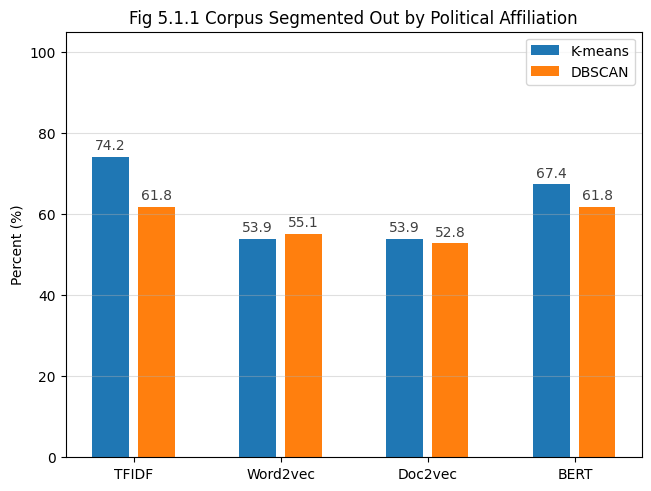

In [24]:
species = ("TFIDF", "Word2vec", "Doc2vec", "BERT")
penguin_means = {
    'K-means': (74.2, 53.9, 53.9, 67.4),
    'DBSCAN': (61.8, 55.1, 52.8, 61.8)
}

x = np.arange(len(species)) # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, alpha = 0.75)
    multiplier += 1.25

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent (%)')
ax.set_title('Fig 5.1.1 Corpus Segmented Out by Political Affiliation')
ax.set_xticks(x + ((width+0.075)/2), species)
ax.legend(loc='upper right')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha = .4)


plt.show()

## DBSCAN

### TFIDF

In [25]:
nbrs_tfidf = NearestNeighbors(n_neighbors = 5).fit(pca_vecs_tfidf)
neigh_dist_tfidf, neigh_ind_tfidf = nbrs_tfidf.kneighbors(pca_vecs_tfidf)
sort_neigh_dist_tfidf = np.sort(neigh_dist_tfidf, axis = 0)
k_dist_tfidf = sort_neigh_dist_tfidf[:, 4]

kneedle_tfidf = KneeLocator(x = range(1, len(neigh_dist_tfidf)+1), y = k_dist_tfidf, S = 1.0, curve = "concave", direction = "increasing", online=True)
clusters_db_tfidf = DBSCAN(eps = kneedle_tfidf.knee_y, min_samples = 4).fit(pca_vecs_tfidf)

Dictionary={'label':docs['labels'], 'cluster':clusters_db_tfidf.labels_}
db_tfidf=pd.DataFrame(Dictionary)

db_tfidf_results = pright(db_tfidf)
db_tfidf_results

({0: {'Democrat': 34, 'Republican': 47}, 1: {'Democrat': 8, 'Republican': 0}},
 0.6179775280898876)

### Word2Vec

In [26]:
nbrs_w2v = NearestNeighbors(n_neighbors = 5).fit(pca_vecs_w2v)
neigh_dist_w2v, neigh_ind_w2v = nbrs_w2v.kneighbors(pca_vecs_w2v)
sort_neigh_dist_w2v = np.sort(neigh_dist_w2v, axis = 0)
k_dist_w2v = sort_neigh_dist_w2v[:, 4]

kneedle_w2v = KneeLocator(x = range(1, len(neigh_dist_w2v)+1), y = k_dist_w2v, S = 1.0, curve = "concave", direction = "increasing", online=True)
clusters_db_w2v = DBSCAN(eps = kneedle_w2v.knee_y, min_samples = 4).fit(pca_vecs_w2v)

Dictionary={'label':docs['labels'], 'cluster':clusters_db_w2v.labels_}
db_w2v=pd.DataFrame(Dictionary)

db_w2v_results = pright(db_w2v)
db_w2v_results

({0: {'Democrat': 2, 'Republican': 0}, 1: {'Democrat': 40, 'Republican': 47}},
 0.550561797752809)

### Doc2Vec

In [27]:
nbrs_d2v = NearestNeighbors(n_neighbors = 5).fit(pca_vecs_d2v)
neigh_dist_d2v, neigh_ind_d2v = nbrs_d2v.kneighbors(pca_vecs_d2v)
sort_neigh_dist_d2v = np.sort(neigh_dist_d2v, axis = 0)
k_dist_d2v = sort_neigh_dist_d2v[:, 4]

kneedle_d2v = KneeLocator(x = range(1, len(neigh_dist_d2v)+1), y = k_dist_d2v, S = 1.0, curve = "concave", direction = "increasing", online=True)
clusters_db_d2v = DBSCAN(eps = kneedle_d2v.knee_y, min_samples = 4).fit(pca_vecs_d2v)

Dictionary={'label':docs['labels'], 'cluster':clusters_db_d2v.labels_}
db_d2v=pd.DataFrame(Dictionary)

db_d2v_results = pright(db_d2v)
db_d2v_results

({0: {'Democrat': 37, 'Republican': 43},
  1: {'Democrat': 2, 'Republican': 3},
  2: {'Democrat': 3, 'Republican': 1}},
 0.449438202247191)

### BERT

In [28]:
print()

In [29]:
nbrs_bert = NearestNeighbors(n_neighbors = 5).fit(pca_vecs_bert)
neigh_dist_bert, neigh_ind_bert = nbrs_bert.kneighbors(pca_vecs_bert)
sort_neigh_dist_bert = np.sort(neigh_dist_bert, axis = 0)
k_dist_bert = sort_neigh_dist_bert[:, 4]

kneedle_bert = KneeLocator(x = range(1, len(neigh_dist_bert)+1), y = k_dist_bert, S = 1.0, curve = "concave", direction = "increasing", online=True)
clusters_db_bert = DBSCAN(eps = 0.1, min_samples = 4).fit(pca_vecs_bert)

Dictionary={'label':docs['labels'], 'cluster':clusters_db_bert.labels_}
db_bert=pd.DataFrame(Dictionary)
clusters_db_bert.labels_
# db_bert_results = pright(db_bert)
# db_bert_results

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0], dtype=int64)

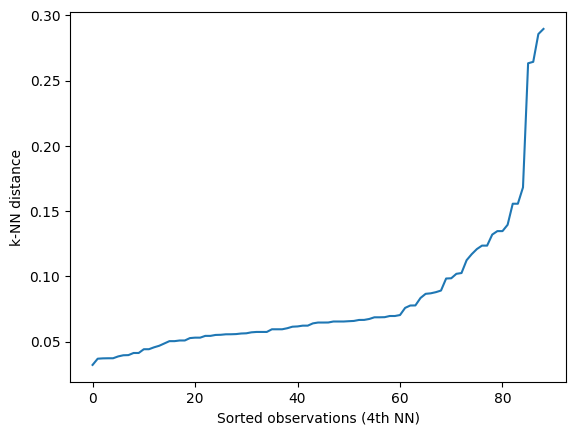

In [30]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist_bert[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

## Hierarchical

### TFIDF

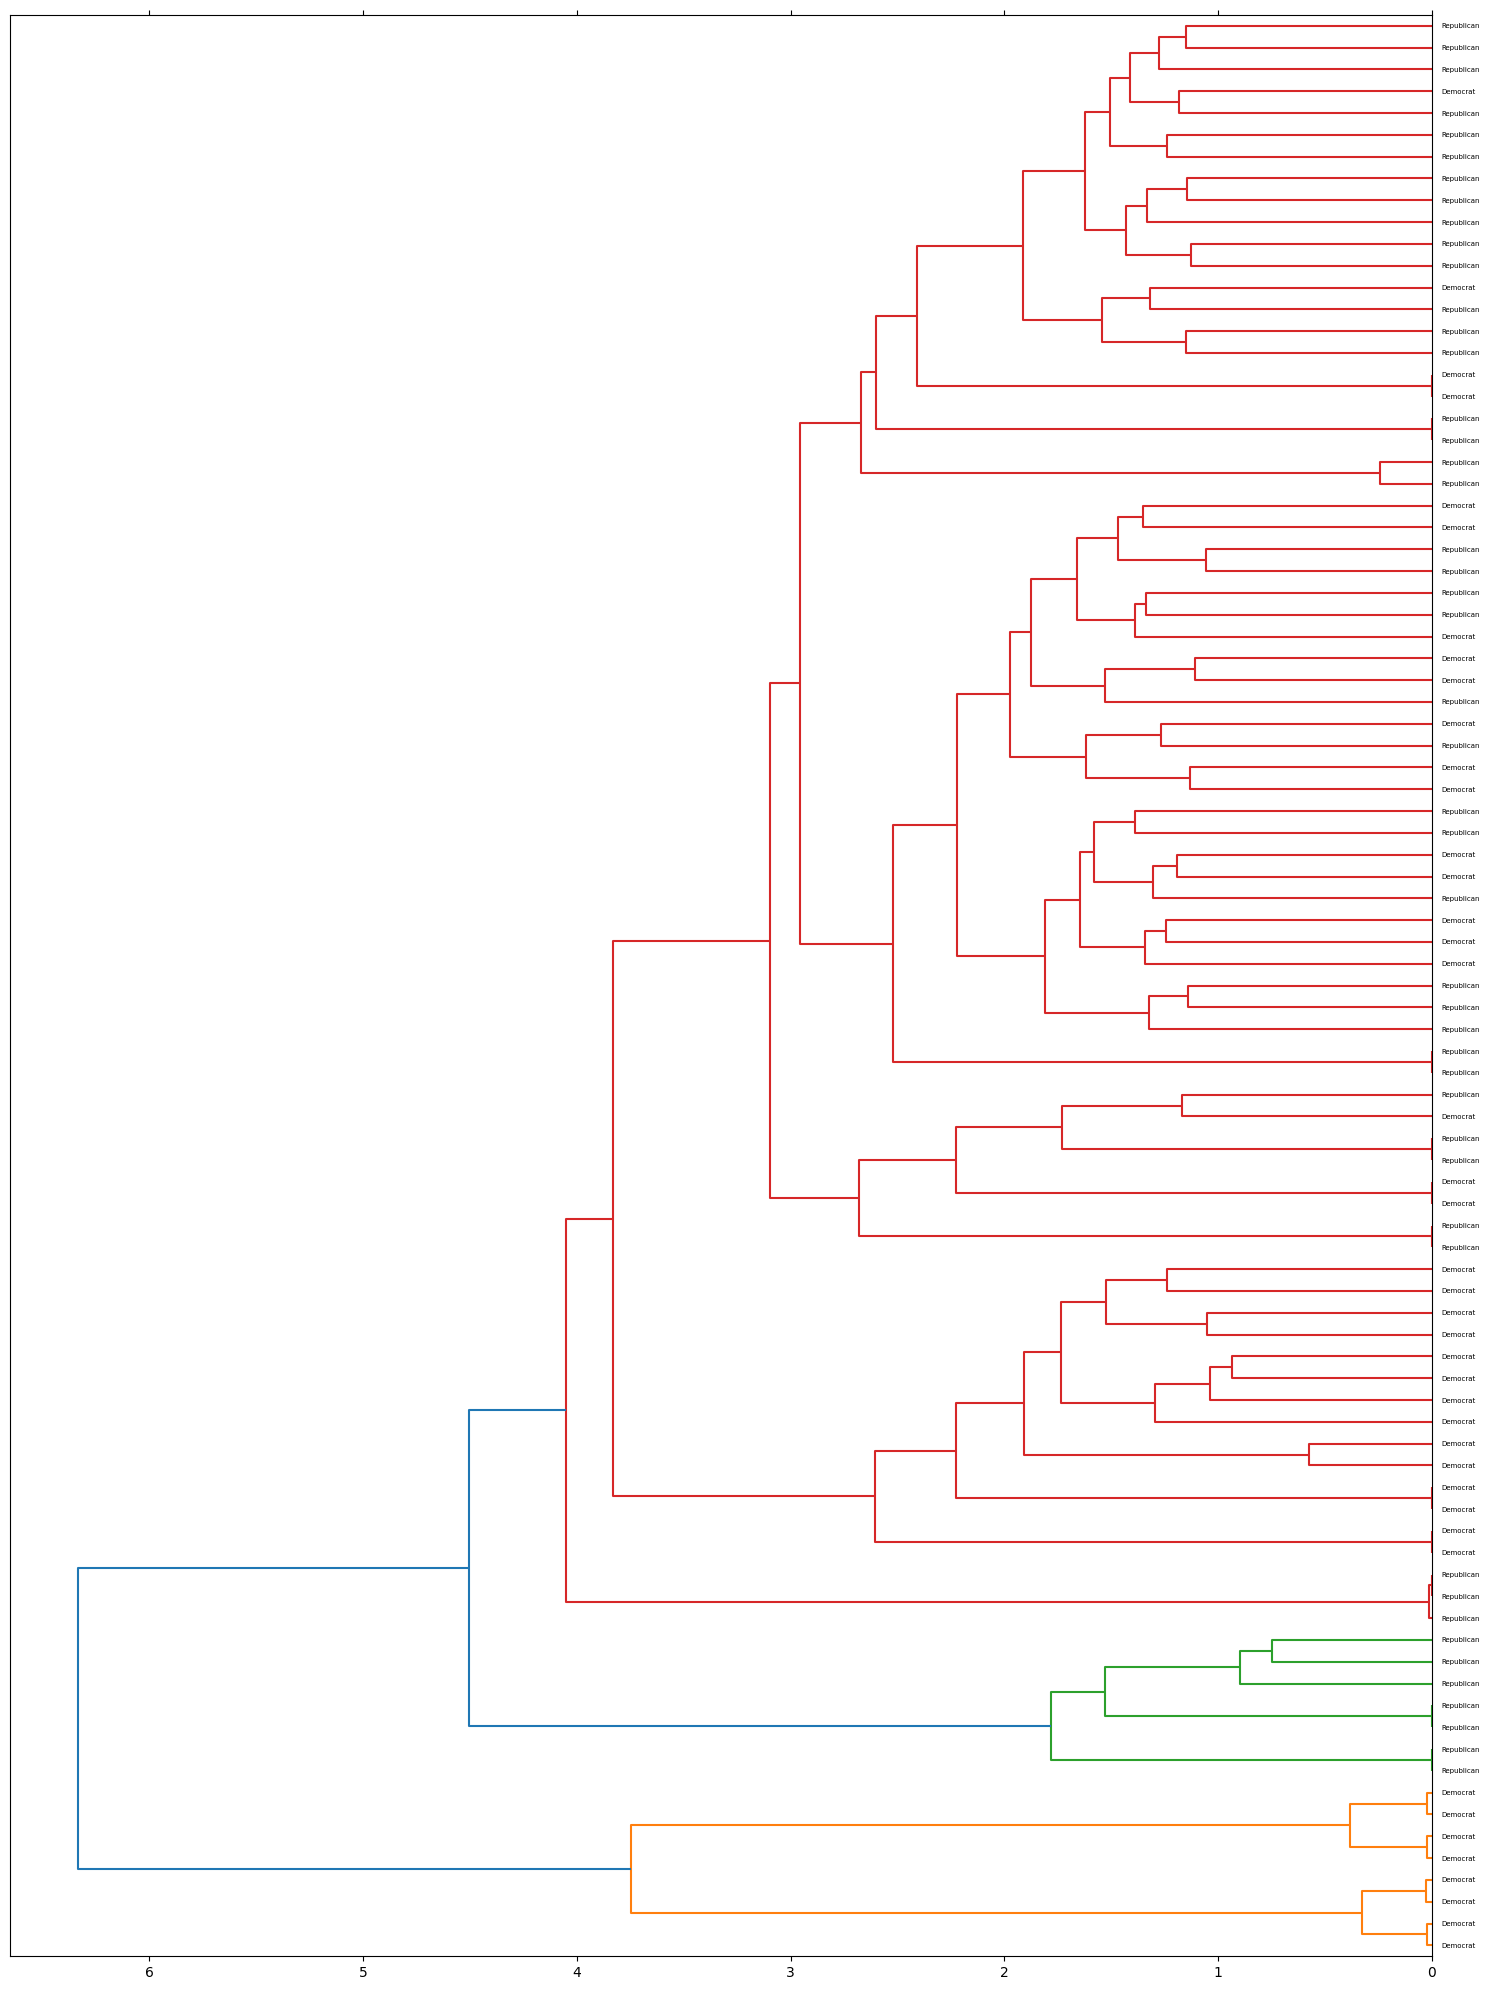

In [31]:
dist = 1 - cosine_similarity(TFIDF_vecs)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=list(docs['labels']))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()

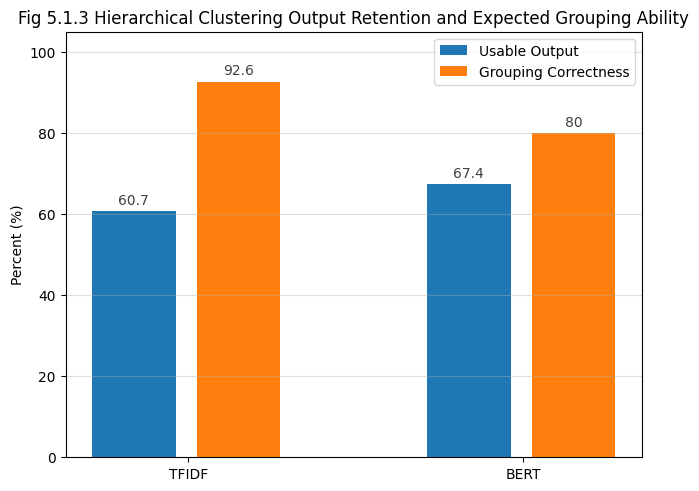

In [36]:
species = ("TFIDF", "BERT")
penguin_means = {
    'Usable Output': (60.7, 67.4),
    'Grouping Correctness': (92.6, 80.0) #48/60 = .8
}

x = np.arange(len(species)) # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, alpha = 0.75)
    multiplier += 1.25

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent (%)')
ax.set_title('Fig 5.1.3 Hierarchical Clustering Output Retention and Expected Grouping Ability')
ax.set_xticks(x + ((width+0.075)/2), species)
ax.legend(loc='upper right')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha = .4)


plt.show()

### Word2vec

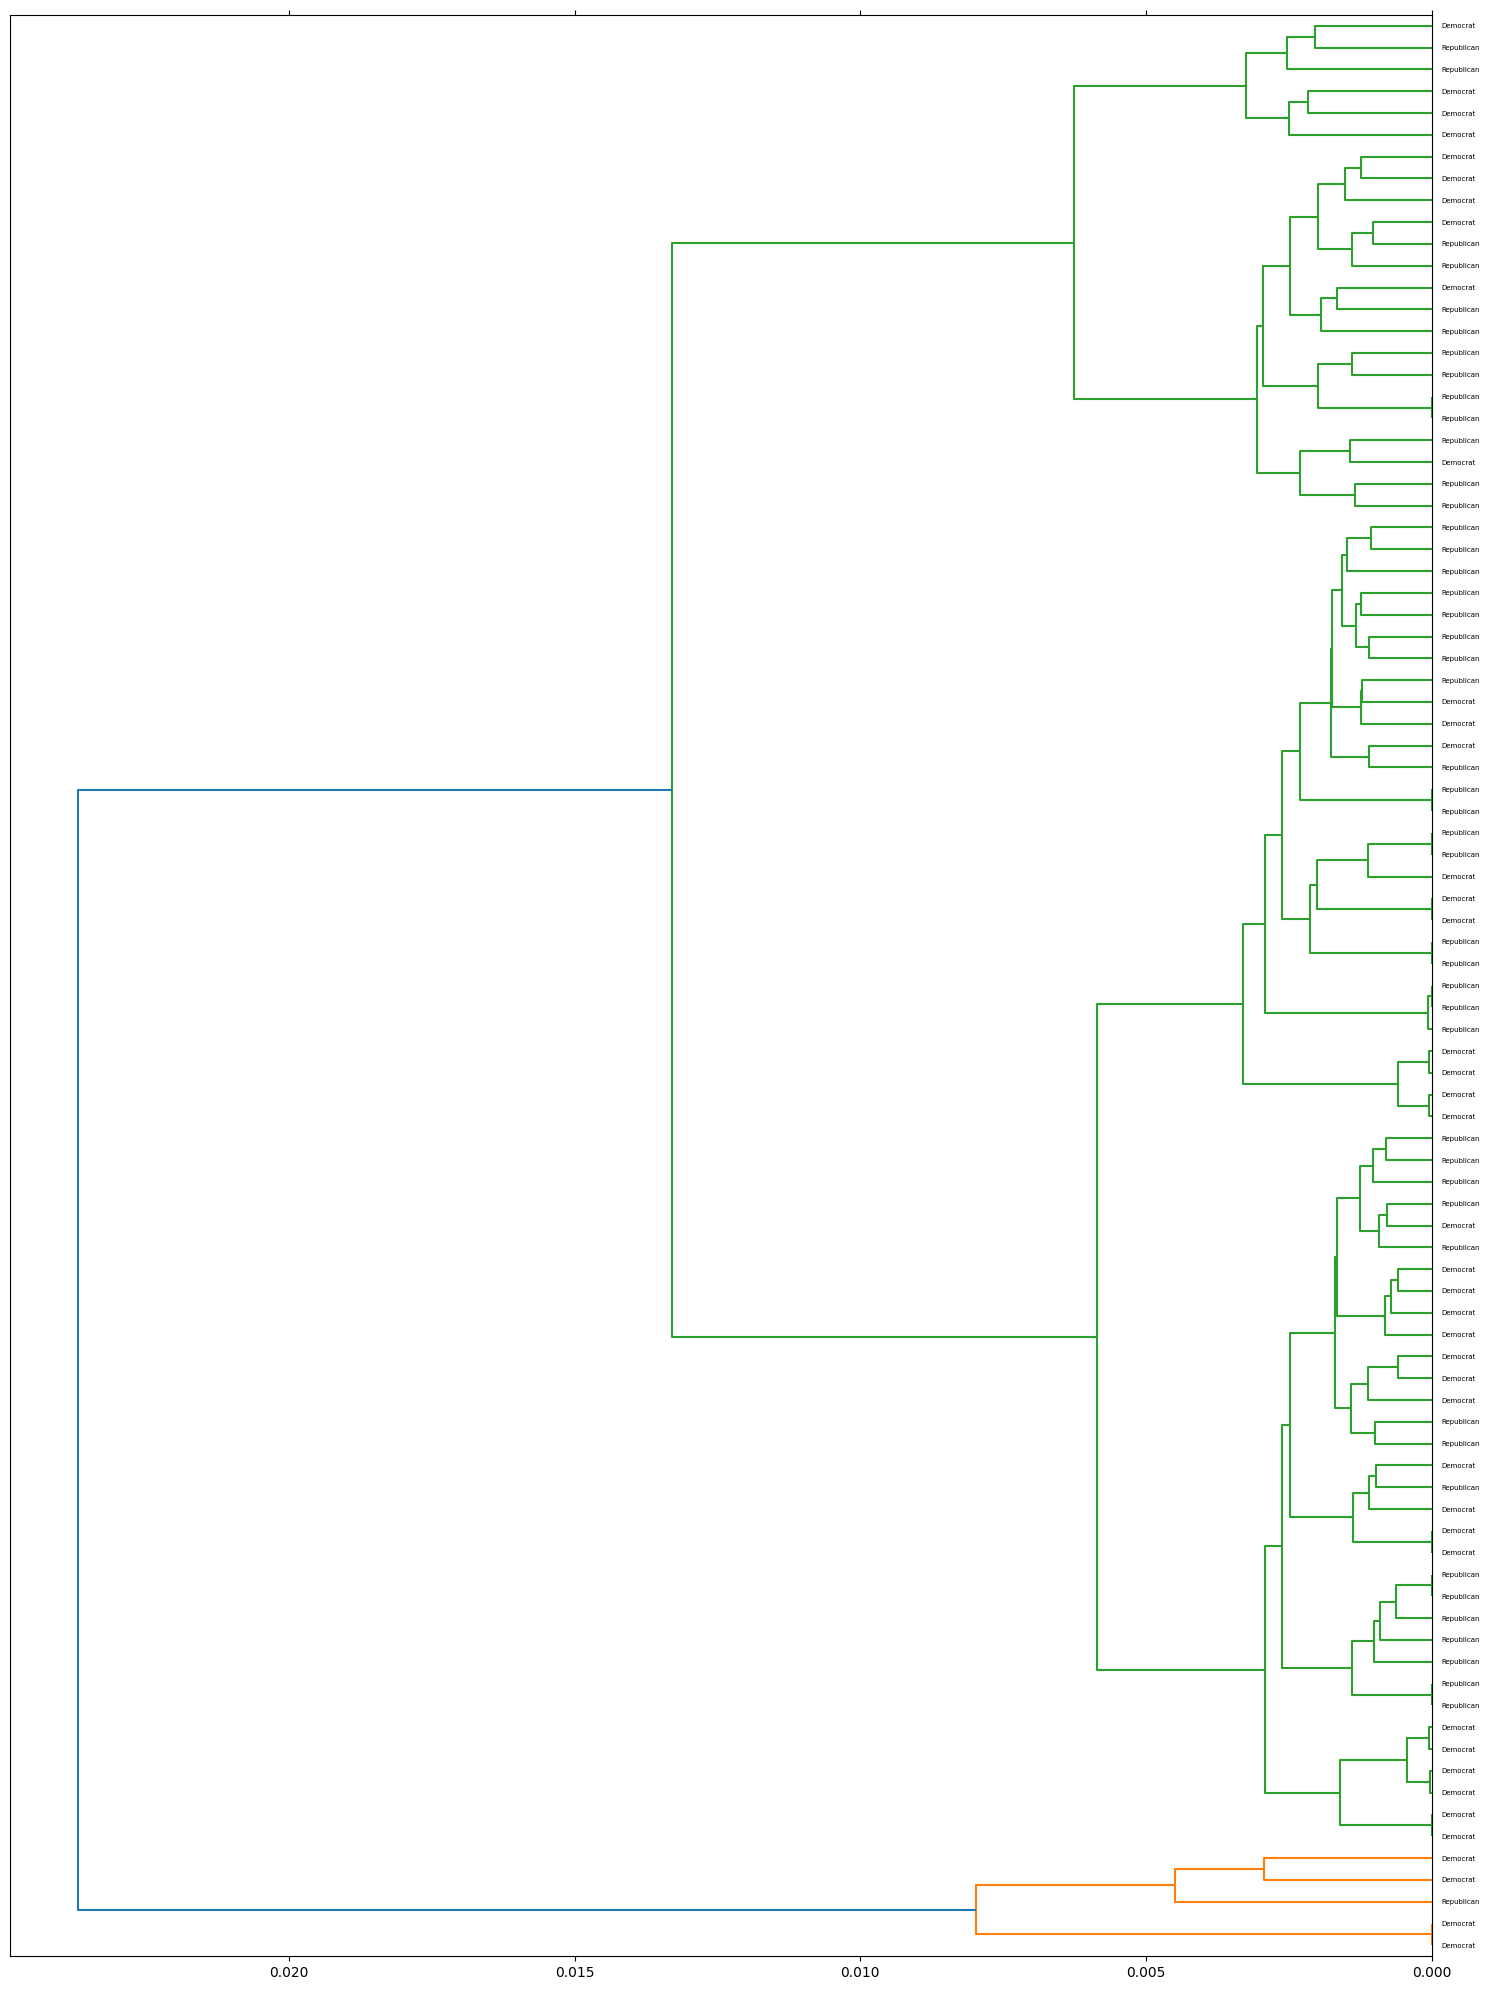

In [32]:
dist = 1 - cosine_similarity(w2v_vecs)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=list(docs['labels']))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()

### Doc2vec

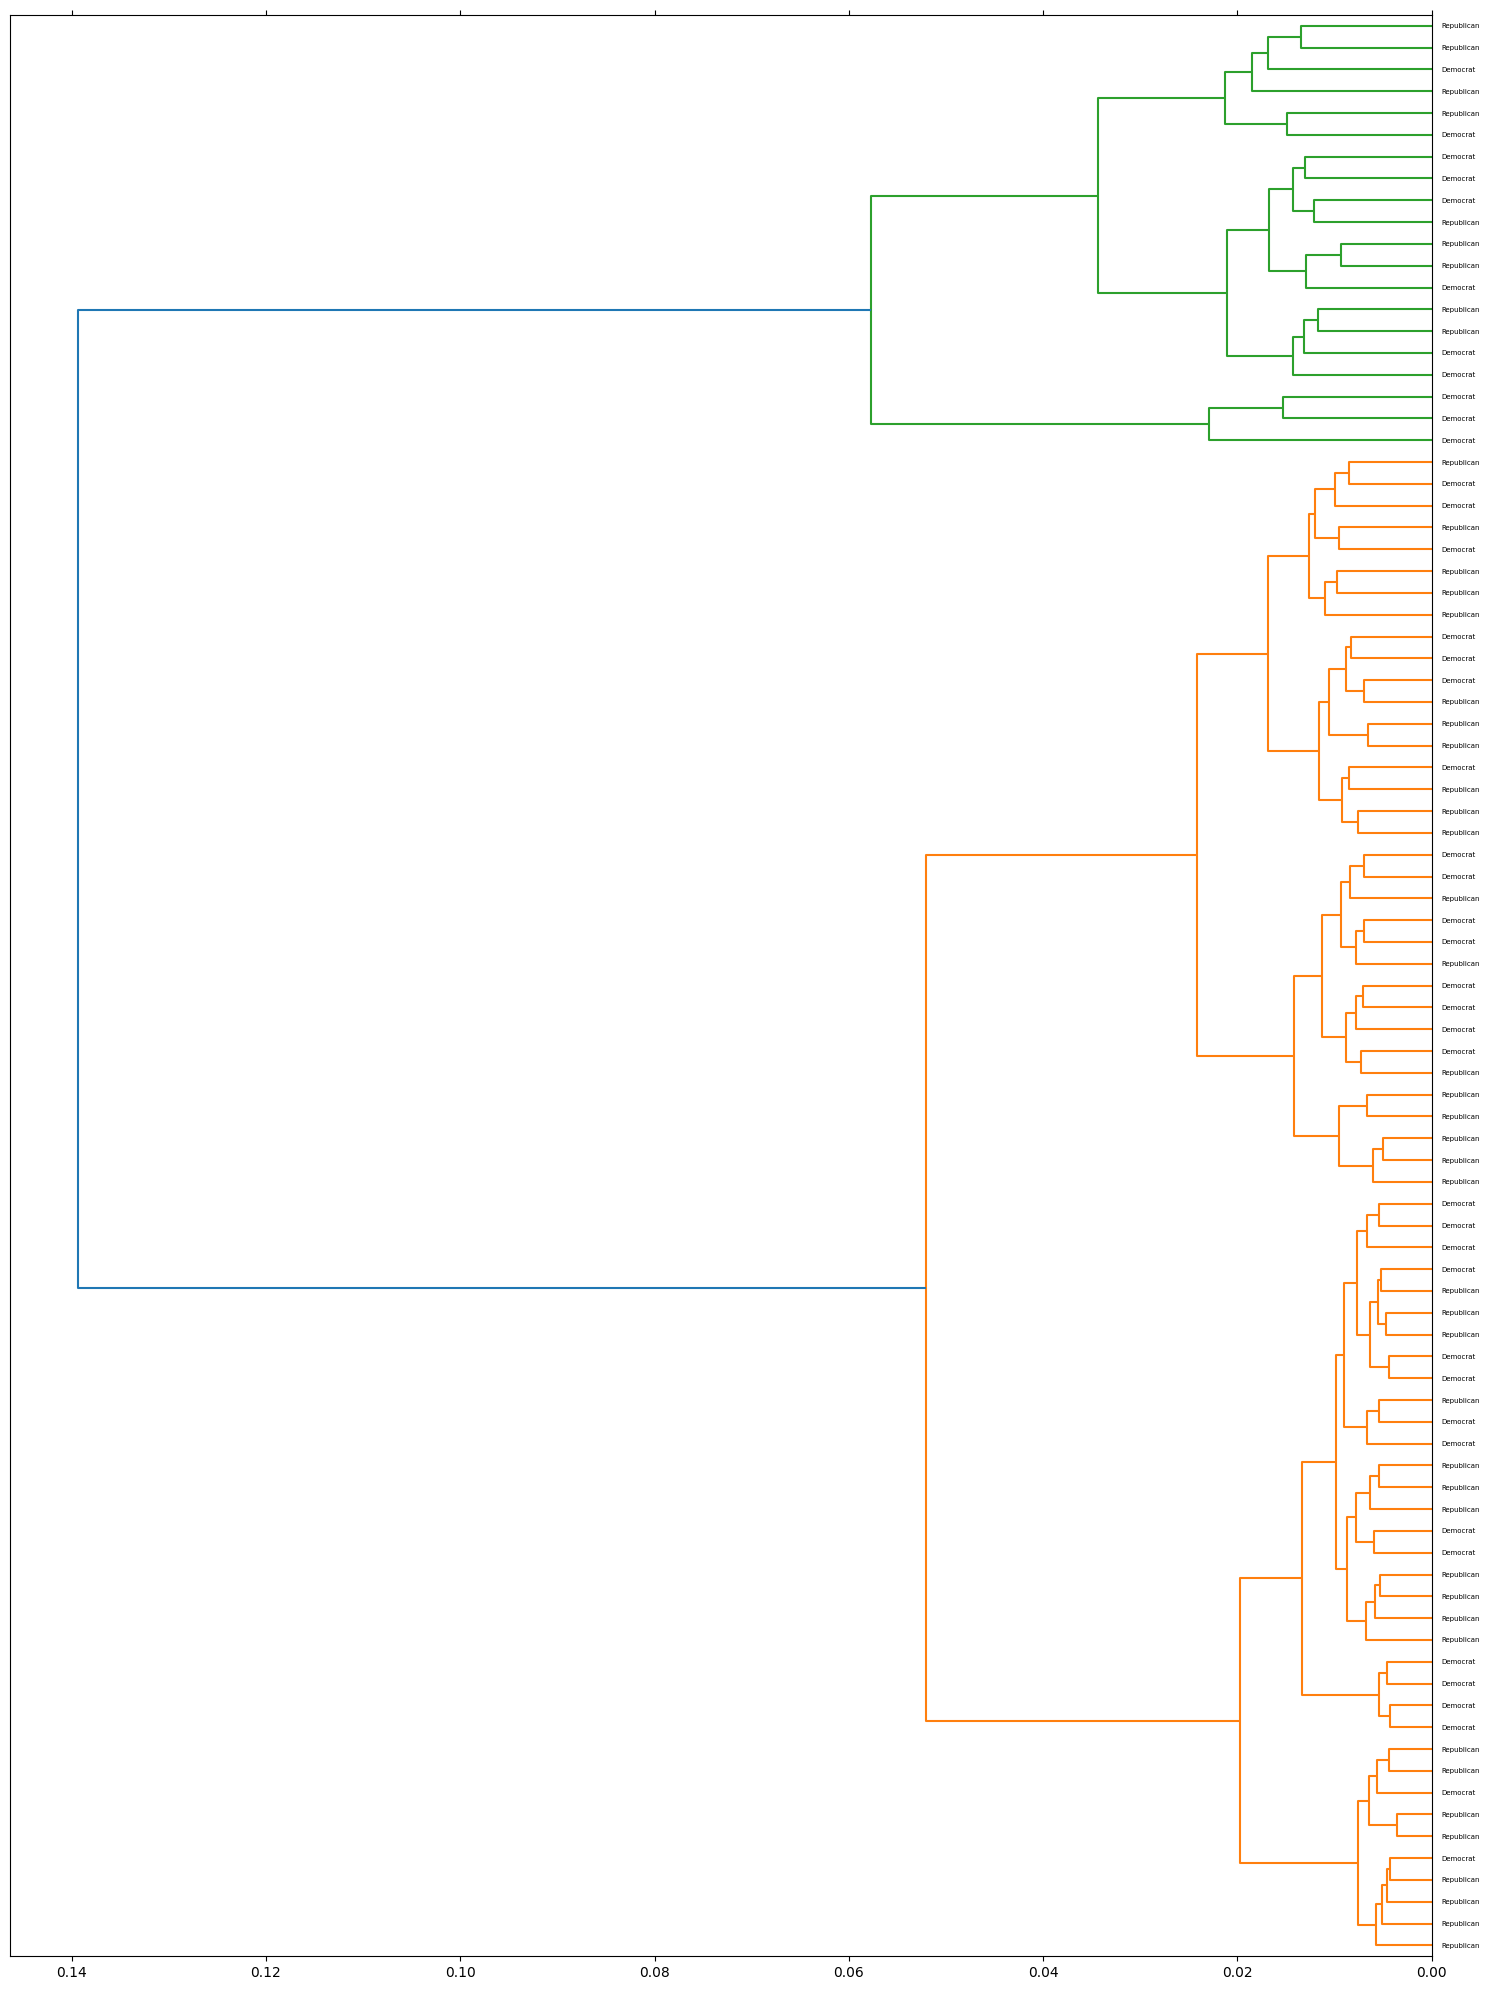

In [33]:

dist = 1 - cosine_similarity(d2v_vecs)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=list(docs['labels']))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()

### BERT

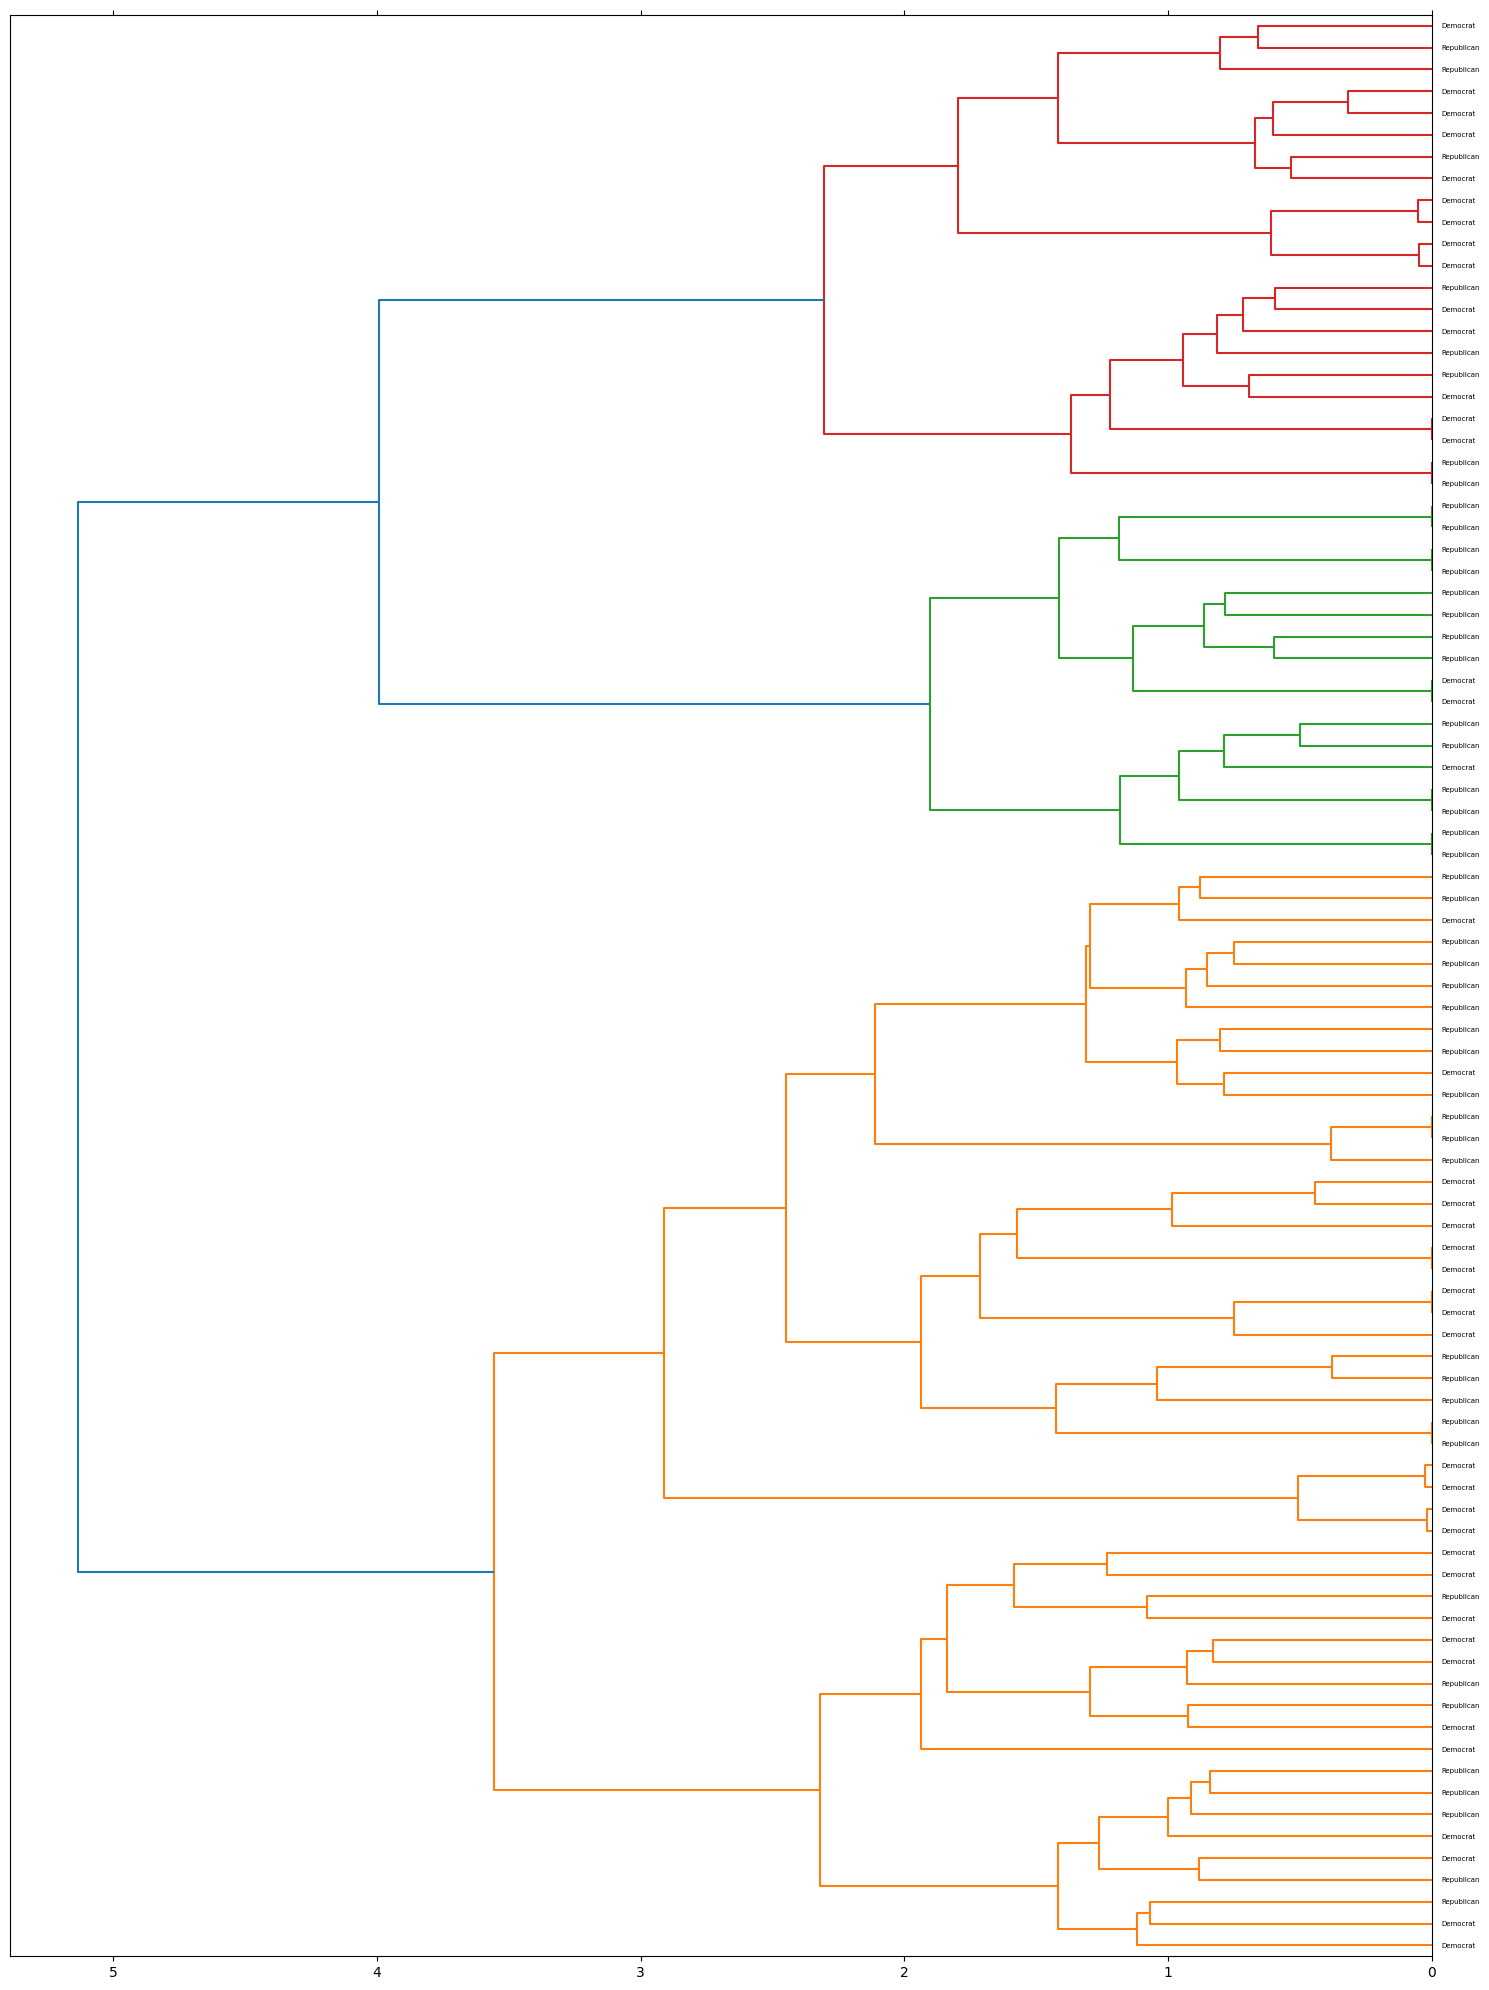

In [34]:
dist = 1 - cosine_similarity(bert_vecs)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=list(docs['labels']))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()